# 2.1.a

## data fetching

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

In [15]:
def fetch_data(sample_size=None):
    # Load MNIST data
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist["data"], mnist["target"].astype(int)

    # Filter digits 2, 3, 8, 9
    mask = np.isin(y, [2, 3, 8, 9])
    X, y = X[mask], y[mask]

    # sample_size
    if sample_size is not None:
        X, y = X[:sample_size], y[:sample_size]

    return X, y

In [12]:
X, y = fetch_data(2500)

/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## without caching or shrinking

In [13]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_labels = [2, 3, 8, 9]

# SVM training function adjusted for one-vs-all strategy
def train_one_vs_all_svm_1a(X, y, class_labels, C=1.0):
    classifiers = []
    m, n = X.shape
    solvers.options['show_progress'] = True  # Enable solver progress output

    for label in class_labels:
        y_binary = np.where(y == label, 1, -1).astype(float)

        N, d = X.shape
        Q = np.zeros((d + 1 + N, d + 1 + N))  # b, w, and epsilon
        Q[1:d+1, 1:d+1] = np.eye(d)
        p = np.hstack([np.zeros(d + 1), C * np.ones(N)])
        
        G_top = np.hstack([-y_binary[:, np.newaxis], -y_binary[:, np.newaxis] * X, -np.eye(N)])
        G_bottom = np.hstack([np.zeros((N, d + 1)), -np.eye(N)])
        G = np.vstack([G_top, G_bottom])
        
        h = np.hstack([-np.ones(N), np.zeros(N)])
        
        # Convert to cvxopt matrices
        Q = matrix(Q)
        p = matrix(p)
        G = matrix(G)
        h = matrix(h)

        # Solve the QP problem
        solution = solvers.qp(Q, p, G, h)
        w = np.array(solution['x']).flatten()
        
        classifiers.append((w[1:d+1], w[0]))

    return classifiers

# Prediction function for one-vs-all SVM
def predict_one_vs_all_svm_1a(X, classifiers, class_labels):
    # Compute the decision function for each classifier
    predictions = np.array([np.dot(X, w) + b for w, b in classifiers])
    # Get the index of the maximum score for each sample across classifiers
    predicted_indices = np.argmax(predictions, axis=0)
    # Map indices to class labels
    return np.array([class_labels[idx] for idx in predicted_indices])


In [14]:
# shapes

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16748, 784)
(16748,)
(4187, 784)
(4187,)


In [ ]:
# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]

for penalty in penalties:
    print(f"Training with penalty value: {penalty}")
    # Train one-vs-all SVM
    classifiers = train_one_vs_all_svm_1a(X_train, y_train, class_labels, C=penalty)

    # Predict using one-vs-all SVM
    y_pred = predict_one_vs_all_svm_1a(X_test, classifiers, class_labels)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy with penalty {penalty}: {accuracy}")

## with shrinking

In [4]:
# get these labels from the dataset
labels = [2, 3, 8, 9]

# Filter digits 2, 3, 8, 9

mask = np.isin(y, labels)
X_masked, y_masked = X[mask], y[mask]

# Reduce the dataset size for debugging

sample_size = 2500  # Use a smaller sample for debugging

X_sample, y_sample = X_masked[:sample_size], y_masked[:sample_size]

# Normalize data
scaler = StandardScaler()
X_sample = scaler.fit_transform(X_sample)

(27914, 784) (27914,)


In [9]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)
labels = [2, 3, 8, 9]

# Filter digits 2, 3, 8, 9
mask = np.isin(y, labels)
X_masked, y_masked = X[mask], y[mask]

# Reduce the dataset size for debugging
sample_size = 10000  # Use a smaller sample for debugging
X_sample, y_sample = X_masked[:sample_size], y_masked[:sample_size]

# Normalize data
scaler = StandardScaler()
X_sample = scaler.fit_transform(X_sample)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

class_labels = [2, 3, 8, 9]

# Cache class to manage kernel caching
class KernelCache:
    def __init__(self, max_size):
        self.cache = {}
        self.max_size = max_size

    def get(self, key):
        return self.cache.get(key)

    def add(self, key, value):
        if len(self.cache) >= self.max_size:
            self.cache.pop(next(iter(self.cache)))  # Remove least recently used
        self.cache[key] = value

# Function to compute the kernel matrix
def compute_kernel(X1, X2):
    return np.dot(X1, X2.T)

# SVM training function with shrinking and caching
def train_one_vs_all_svm(X, y, class_labels, C=1.0, tol=1e-5, max_iter=1000, cache_size=500):
    classifiers = []
    m, n = X.shape
    solvers.options['show_progress'] = False  # Disable solver progress output
    solvers.options['abstol'] = tol
    solvers.options['reltol'] = tol
    solvers.options['maxiters'] = max_iter

    kernel_cache = KernelCache(max_size=cache_size)

    for label in class_labels:
        y_binary = np.where(y == label, 1, -1).astype(float)
        N, d = X.shape
        Q = np.zeros((d + 1 + N, d + 1 + N))  # b, w, and epsilon
        Q[1:d+1, 1:d+1] = np.eye(d)
        p = np.hstack([np.zeros(d + 1), C * np.ones(N)])
        
        G_top = np.hstack([-y_binary[:, np.newaxis], -y_binary[:, np.newaxis] * X, -np.eye(N)])
        G_bottom = np.hstack([np.zeros((N, d + 1)), -np.eye(N)])
        G = np.vstack([G_top, G_bottom])
        
        h = np.hstack([-np.ones(N), np.zeros(N)])
        
        # Convert to cvxopt matrices
        Q = matrix(Q)
        p = matrix(p)
        G = matrix(G)
        h = matrix(h)

        # Shrinking procedure
        active_set = np.arange(N)
        inactive_set = np.array([], dtype=int)

        for _ in range(max_iter):
            if len(active_set) == 0:
                break

            active_indices = np.hstack([np.arange(d+1), active_set + (d+1)])
            active_indices = np.array(active_indices, dtype=int)

            active_Q = np.zeros((len(active_indices), len(active_indices)))
            for i, idx_i in enumerate(active_indices):
                for j, idx_j in enumerate(active_indices):
                    cache_key = (idx_i, idx_j)
                    if kernel_cache.get(cache_key) is None:
                        if idx_i < d+1 or idx_j < d+1:
                            value = Q[idx_i, idx_j]
                        else:
                            X_i = X[(idx_i - (d+1)) % N]
                            X_j = X[(idx_j - (d+1)) % N]
                            value = compute_kernel(X_i[np.newaxis, :], X_j[np.newaxis, :])[0, 0]
                        kernel_cache.add(cache_key, value)
                    active_Q[i, j] = kernel_cache.get(cache_key)

            active_Q = matrix(active_Q)
            active_p = np.array(p)[active_indices]
            active_p = matrix(active_p)
            active_G = np.array(G)[:len(active_set)*2, :][:, active_indices]
            active_G = matrix(active_G)
            active_h = np.array(h)[:len(active_set)*2]
            active_h = matrix(active_h)

            solution = solvers.qp(active_Q, active_p, active_G, active_h)
            w = np.array(solution['x']).flatten()

            # Check for optimality and update active/inactive sets
            new_active_set = []
            for i in active_set:
                if abs(w[d+1+i]) >= tol:
                    new_active_set.append(i)
                else:
                    inactive_set = np.append(inactive_set, i)
            active_set = np.array(new_active_set)

            if len(active_set) == len(new_active_set):
                break  # No change in the active set, stop iterating

        classifiers.append((w[1:d+1], w[0]))

    return classifiers

# Prediction function for one-vs-all SVM
def predict_one_vs_all_svm(X, classifiers, class_labels):
    # Compute the decision function for each classifier
    predictions = np.array([np.dot(X, w) + b for w, b in classifiers])
    # Get the index of the maximum score for each sample across classifiers
    predicted_indices = np.argmax(predictions, axis=0)
    # Map indices to class labels
    return np.array([class_labels[idx] for idx in predicted_indices])

# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]

for penalty in penalties:
    print(f"Training with penalty value: {penalty}")
    # Train one-vs-all SVM
    classifiers = train_one_vs_all_svm(X_train, y_train, class_labels, C=penalty)

    # Predict using one-vs-all SVM
    y_pred = predict_one_vs_all_svm(X_test, classifiers, class_labels)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy with penalty {penalty}: {accuracy}")


Training with penalty value: 0.01
     pcost       dcost       gap    pres   dres
 0:  1.7203e+00  1.7005e+02  1e+04  3e+00  2e+04
 1:  3.9163e+01 -2.8554e+02  3e+02  5e-02  3e+02
 2:  2.9244e+01 -3.6674e+01  7e+01  8e-03  5e+01
 3:  1.4164e+01 -8.4052e+00  2e+01  3e-03  1e+01
 4:  5.9967e+00 -1.9613e+00  8e+00  9e-04  5e+00
 5:  3.0410e+00 -1.1282e-01  3e+00  3e-04  1e+00
 6:  1.4206e+00  7.3606e-01  7e-01  5e-05  3e-01
 7:  1.1010e+00  9.1832e-01  2e-01  8e-06  5e-02
 8:  1.0147e+00  9.6845e-01  5e-02  1e-06  8e-03
 9:  9.8951e-01  9.8422e-01  5e-03  4e-08  2e-04
10:  9.8661e-01  9.8642e-01  2e-04  1e-09  6e-06
11:  9.8651e-01  9.8650e-01  4e-06  2e-11  1e-07
12:  9.8650e-01  9.8650e-01  1e-07  5e-13  3e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0777e+00  1.9280e+02  1e+04  3e+00  1e+04
 1:  3.8908e+01 -3.2995e+02  4e+02  6e-02  3e+02
 2:  3.0344e+01 -3.7445e+01  7e+01  9e-03  4e+01
 3:  1.4793e+01 -7.5367e+00  2e+01  2e-03  1e+01
 4:  7.6596e+

## with caching and shrinking

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)
labels = [2, 3, 8, 9]

# Filter digits 2, 3, 8, 9
mask = np.isin(y, labels)
X_masked, y_masked = X[mask], y[mask]

# Reduce the dataset size for debugging
sample_size = 2500  # Use a smaller sample for debugging
X_sample, y_sample = X_masked[:sample_size], y_masked[:sample_size]

# Normalize data
scaler = StandardScaler()
X_sample = scaler.fit_transform(X_sample)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

class_labels = [2, 3, 8, 9]


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [11]:
# Cache class to manage kernel caching
class KernelCache:
    def __init__(self, max_size):
        self.cache = {}
        self.max_size = max_size

    def get(self, key):
        return self.cache.get(key)

    def add(self, key, value):
        if len(self.cache) >= self.max_size:
            self.cache.pop(next(iter(self.cache)))  # Remove least recently used
        self.cache[key] = value

# Function to compute the kernel matrix
def compute_kernel(X1, X2):
    return np.dot(X1, X2.T)

# SVM training function with shrinking and caching
def train_one_vs_all_svm(X, y, class_labels, C=1.0, tol=1e-5, max_iter=1000, cache_size=500):
    classifiers = []
    m, n = X.shape
    solvers.options['show_progress'] = False  # Disable solver progress output
    solvers.options['abstol'] = tol
    solvers.options['reltol'] = tol
    solvers.options['maxiters'] = max_iter

    kernel_cache = KernelCache(max_size=cache_size)

    for label in class_labels:
        y_binary = np.where(y == label, 1, -1).astype(float)
        N, d = X.shape
        Q_np = np.zeros((d + 1 + N, d + 1 + N))  # b, w, and epsilon
        Q_np[1:d+1, 1:d+1] = np.eye(d)
        p = np.hstack([np.zeros(d + 1), C * np.ones(N)])
        
        G_top = np.hstack([-y_binary[:, np.newaxis], -y_binary[:, np.newaxis] * X, -np.eye(N)])
        G_bottom = np.hstack([np.zeros((N, d + 1)), -np.eye(N)])
        G = np.vstack([G_top, G_bottom])
        
        h = np.hstack([-np.ones(N), np.zeros(N)])
        
        # Convert to cvxopt matrices
        Q = matrix(Q_np)
        p = matrix(p)
        G = matrix(G)
        h = matrix(h)

        # Shrinking procedure
        active_set = np.arange(N)
        inactive_set = np.array([], dtype=int)

        for _ in range(max_iter):
            if len(active_set) == 0:
                break

            active_indices = np.hstack([np.arange(d+1), active_set + (d+1)])
            active_indices = np.array(active_indices, dtype=int)

            active_Q = np.zeros((len(active_indices), len(active_indices)))
            for i, idx_i in enumerate(active_indices):
                for j, idx_j in enumerate(active_indices):
                    cache_key = (idx_i, idx_j)
                    if kernel_cache.get(cache_key) is None:
                        if idx_i < d+1 or idx_j < d+1:
                            value = Q_np[idx_i, idx_j]
                        else:
                            X_i = X[(idx_i - (d+1)) % N]
                            X_j = X[(idx_j - (d+1)) % N]
                            value = compute_kernel(X_i[np.newaxis, :], X_j[np.newaxis, :])[0, 0]
                        kernel_cache.add(cache_key, value)
                    active_Q[i, j] = kernel_cache.get(cache_key)

            active_Q = matrix(active_Q)
            active_p = np.array(p)[active_indices]
            active_p = matrix(active_p)
            active_G = np.array(G)[:len(active_set)*2, :][:, active_indices]
            active_G = matrix(active_G)
            active_h = np.array(h)[:len(active_set)*2]
            active_h = matrix(active_h)

            solution = solvers.qp(active_Q, active_p, active_G, active_h)
            w = np.array(solution['x']).flatten()

            # Check for optimality and update active/inactive sets
            new_active_set = []
            for i in active_set:
                if abs(w[d+1+i]) >= tol:
                    new_active_set.append(i)
                else:
                    inactive_set = np.append(inactive_set, i)
            active_set = np.array(new_active_set)

            if len(active_set) == len(new_active_set):
                break  # No change in the active set, stop iterating

        classifiers.append((w[1:d+1], w[0]))

    return classifiers

# Prediction function for one-vs-all SVM
def predict_one_vs_all_svm(X, classifiers, class_labels):
    # Compute the decision function for each classifier
    predictions = np.array([np.dot(X, w) + b for w, b in classifiers])
    # Get the index of the maximum score for each sample across classifiers
    predicted_indices = np.argmax(predictions, axis=0)
    # Map indices to class labels
    return np.array([class_labels[idx] for idx in predicted_indices])

# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]

for penalty in penalties:
    print(f"Training with penalty value: {penalty}")
    # Train one-vs-all SVM
    classifiers = train_one_vs_all_svm(X_train, y_train, class_labels, C=penalty)

    # Predict using one-vs-all SVM
    y_pred = predict_one_vs_all_svm(X_test, classifiers, class_labels)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy with penalty {penalty}: {accuracy}")

Training with penalty value: 0.01
Accuracy with penalty 0.01: 0.898
Training with penalty value: 0.1
Accuracy with penalty 0.1: 0.898
Training with penalty value: 1
Accuracy with penalty 1: 0.898
Training with penalty value: 10
Accuracy with penalty 10: 0.898
Training with penalty value: 100
Accuracy with penalty 100: 0.898


In [8]:

# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]

for penalty in penalties:
    print(f"Training with penalty value: {penalty}")
    # Train one-vs-all SVM
    classifiers = train_one_vs_all_svm(X_train, y_train, class_labels, C=penalty)

    # Predict using one-vs-all SVM
    y_pred = predict_one_vs_all_svm(X_test, classifiers, class_labels)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy with penalty {penalty}: {accuracy}")

Training with penalty value: 0.01
Accuracy with penalty 0.01: 0.92
Training with penalty value: 0.1
Accuracy with penalty 0.1: 0.908
Training with penalty value: 1
Accuracy with penalty 1: 0.898
Training with penalty value: 10
Accuracy with penalty 10: 0.898
Training with penalty value: 100
Accuracy with penalty 100: 0.898


# 2.1.b
train a 4-class SVM using the scikit-learn’s soft margin primal
SVM function with linear kernel. Please tune the hyperparameters and
report your training and test accuracy. Compare the results with part
(a) regarding classification accuracy and training time.

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import time

In [33]:
def b1(X, y): 
    # Normalize data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100]
    }

    # Initialize LinearSVC
    linear_svc = LinearSVC(multi_class='ovr', max_iter=10000)

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(linear_svc, param_grid, cv=5, verbose=2, n_jobs=-1)

    # Measure training time
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Evaluate the model
    train_accuracies = []
    test_accuracies = []

    for C_value in param_grid['C']:
        # Train the model with the specific C value
        model = LinearSVC(C=C_value, multi_class='ovr', max_iter=10000)
        model.fit(X_train, y_train)
        
        # Predict on training data
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_accuracies.append(train_accuracy)
        
        # Predict on test data
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_accuracy)

        print(f"C = {C_value} | Training Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}")

    print(f"Training Time: {training_time:.2f} seconds")

## 2.1.c
Train a 4-class non-linear SVM using one-vs-all. Please train the
dual formulation of SVM from scratch using a quadratic programming
solver. Please clearly write the expressions you feed to the solver. You
may choose any kernel you like. Please tune the hyperparameters and
report your training and test accuracy

In [17]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers

# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(int)

# Filter digits 2, 3, 8, 9
mask = np.isin(y, [2, 3, 8, 9])
X, y = X[mask], y[mask]

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Sample data
sample_size = 2500
X, y = X[:sample_size], y[:sample_size]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [38]:
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

def compute_kernel_matrix(X, gamma):
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = rbf_kernel(X[i], X[j], gamma)
    return K


In [41]:
def train_one_vs_all_svm_1c(X, y, class_labels, C, gamma):
    classifiers = []
    K = compute_kernel_matrix(X, gamma)
    N = X.shape[0]

    for label in class_labels:
        y_binary = np.where(y == label, 1, -1).astype(float)
        
        P = matrix(np.outer(y_binary, y_binary) * K)
        q = matrix(-np.ones(N))
        G = matrix(np.vstack((-np.eye(N), np.eye(N))))
        h = matrix(np.hstack((np.zeros(N), C * np.ones(N))))
        A = matrix(y_binary, (1, N), 'd')
        b = matrix(0.0)
        
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(sol['x'])

        support_vectors = alphas > 1e-5
        ind = np.arange(len(alphas))[support_vectors]
        alphas = alphas[support_vectors]
        support_vectors_X = X[support_vectors]
        support_vectors_y = y_binary[support_vectors]

        w = np.sum(alphas[:, None] * support_vectors_y[:, None] * support_vectors_X, axis=0)
        b = np.mean([support_vectors_y[i] - np.sum(alphas * support_vectors_y * K[ind[i], support_vectors])
                     for i in range(len(alphas))])
        classifiers.append((alphas, support_vectors_X, support_vectors_y, b))

    return classifiers


In [42]:
def project(X, alphas, support_vectors_X, support_vectors_y, b, gamma):
    y_predict = np.zeros(len(X))
    for i in range(len(X)):
        s = 0
        for alpha, sv_y, sv in zip(alphas, support_vectors_y, support_vectors_X):
            s += alpha * sv_y * rbf_kernel(X[i], sv, gamma)
        y_predict[i] = s
    return y_predict + b

def predict_one_vs_all_svm_1c(X, classifiers, class_labels, gamma):
    predictions = np.array([project(X, alphas, support_vectors_X, support_vectors_y, b, gamma) 
                            for alphas, support_vectors_X, support_vectors_y, b in classifiers])
    y_pred_indices = np.argmax(predictions, axis=0)
    y_pred_labels = np.array([class_labels[idx] for idx in y_pred_indices])
    return y_pred_labels


In [19]:
# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]
gamma_values = [0.01, 0.05, 0.1]

# Train and evaluate for each combination of penalty and gamma value
for penalty in penalties:
    for gamma in gamma_values:
        print(f"Training with penalty value: {penalty}, gamma value: {gamma}")
        classifiers = train_one_vs_all_svm_1c(X_train, y_train, class_labels, C=penalty, gamma=gamma)
        y_pred = predict_one_vs_all_svm_1c(X_test, classifiers, class_labels, gamma)

        accuracy = np.mean(y_pred == y_test)
        print(f"Accuracy with penalty {penalty} and gamma {gamma}: {accuracy}")

Training with penalty value: 0.01, gamma value: 0.01
Accuracy with penalty 0.01 and gamma 0.01: 0.418
Training with penalty value: 0.01, gamma value: 0.05
Accuracy with penalty 0.01 and gamma 0.05: 0.252
Training with penalty value: 0.01, gamma value: 0.1
Accuracy with penalty 0.01 and gamma 0.1: 0.252
Training with penalty value: 0.1, gamma value: 0.01
Accuracy with penalty 0.1 and gamma 0.01: 0.696
Training with penalty value: 0.1, gamma value: 0.05
Accuracy with penalty 0.1 and gamma 0.05: 0.252
Training with penalty value: 0.1, gamma value: 0.1
Accuracy with penalty 0.1 and gamma 0.1: 0.252
Training with penalty value: 1, gamma value: 0.01
Accuracy with penalty 1 and gamma 0.01: 0.782
Training with penalty value: 1, gamma value: 0.05
Accuracy with penalty 1 and gamma 0.05: 0.26
Training with penalty value: 1, gamma value: 0.1
Accuracy with penalty 1 and gamma 0.1: 0.252
Training with penalty value: 10, gamma value: 0.01
Accuracy with penalty 10 and gamma 0.01: 0.792
Training with p

## 2.1.d
Please train a 4-class SVM using the scikit-learn’s soft margin dual
SVM function with a non-linear kernel. You may choose any kernel
you like. Please tune the hyperparameters and report your training and
test accuracy. Compare the results with part (c) regarding classification
accuracy and training time.

In [20]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Sample data
sample_size = 2500
X, y = X[:sample_size], y[:sample_size]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

In [26]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1]
}

# Initialize SVM with RBF kernel
svc = SVC(kernel='rbf')

# Measure training time for scikit-learn implementation
start_time = time.time()
# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
sklearn_training_time = time.time() - start_time
print(f"scikit-learn implementation training time: {sklearn_training_time} seconds")

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_svc = grid_search.best_estimator_

# Evaluate on training and test data
train_accuracy = best_svc.score(X_train, y_train)
test_accuracy = best_svc.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")



Fitting 5 folds for each of 25 candidates, totalling 125 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Int

# 2.2
Feature extraction

In [16]:
from sklearn.decomposition import PCA

X, y = fetch_data(2500)

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}, reduced shape: {X_pca.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Original shape: (2500, 784), reduced shape: (2500, 229)


### repeat 2.1.a

In [17]:
# Define a range of slack values to test
penalties = [0.01, 0.1, 1, 10, 100]

for penalty in penalties:
    print(f"Training with penalty value: {penalty}")
    # Train one-vs-all SVM
    classifiers = train_one_vs_all_svm_1a(X_train, y_train, class_labels, C=penalty)

    # Predict using one-vs-all SVM
    y_pred = predict_one_vs_all_svm_1a(X_test, classifiers, class_labels)

    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy with penalty {penalty}: {accuracy}")

Training with penalty value: 0.01
     pcost       dcost       gap    pres   dres
 0:  1.5683e+00  2.1048e+02  2e+04  3e+00  2e+04
 1:  4.2535e+01 -2.4975e+02  3e+02  4e-02  2e+02
 2:  2.9788e+01 -3.0577e+01  6e+01  7e-03  4e+01
 3:  1.2327e+01 -5.2129e+00  2e+01  2e-03  9e+00
 4:  6.1915e+00 -1.5095e+00  8e+00  6e-04  4e+00
 5:  3.2485e+00  8.7753e-02  3e+00  2e-04  1e+00
 6:  1.8290e+00  7.7850e-01  1e+00  6e-05  3e-01
 7:  1.3116e+00  1.0331e+00  3e-01  6e-06  3e-02
 8:  1.1811e+00  1.1039e+00  8e-02  8e-07  5e-03
 9:  1.1435e+00  1.1278e+00  2e-02  1e-07  7e-04
10:  1.1360e+00  1.1327e+00  3e-03  1e-15  9e-14
11:  1.1343e+00  1.1342e+00  1e-04  1e-15  1e-13
12:  1.1342e+00  1.1342e+00  6e-06  1e-15  9e-13
13:  1.1342e+00  1.1342e+00  2e-07  1e-15  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8934e+00  2.5026e+02  2e+04  3e+00  2e+04
 1:  4.8184e+01 -3.0358e+02  4e+02  5e-02  2e+02
 2:  3.4530e+01 -3.6286e+01  7e+01  7e-03  4e+01
 3:  1.5713e+

## repeat 2.1.b

In [21]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [34]:
b1(X_pca, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel

/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................................C=10; total time=   3.4s
[CV] END ...............................................C=10; total time=   3.6s


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................................C=10; total time=   3.9s


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................................C=10; total time=   3.6s


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............................................C=10; total time=   3.4s
[CV] END ..............................................C=100; total time=   3.3s


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................................C=100; total time=   3.6s
[CV] END ..............................................C=100; total time=   3.7s


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..............................................C=100; total time=   3.0s
[CV] END ..............................................C=100; total time=   3.1s
Best parameters: {'C': 0.01}
C = 0.01 | Training Accuracy: 0.973 | Test Accuracy: 0.902
C = 0.1 | Training Accuracy: 0.987 | Test Accuracy: 0.888
C = 1 | Training Accuracy: 0.995 | Test Accuracy: 0.882


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C = 10 | Training Accuracy: 0.988 | Test Accuracy: 0.858
C = 100 | Training Accuracy: 0.982 | Test Accuracy: 0.842
Training Time: 10.49 seconds


/Users/osmanyasinbastug/miniconda3/envs/mlpro/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## repeat 2.1.c

In [47]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [48]:
# Define a range of slack values to test
penalties = [10]
gamma_values = [0.01]

# Train and evaluate for each combination of penalty and gamma value
for penalty in penalties:
    for gamma in gamma_values:
        print(f"Training with penalty value: {penalty}, gamma value: {gamma}")
        classifiers = train_one_vs_all_svm_1c(X_train, y_train, class_labels, C=penalty, gamma=gamma)
        y_pred = predict_one_vs_all_svm_1c(X_test, classifiers, class_labels, gamma)

        accuracy = np.mean(y_pred == y_test)
        print(f"Accuracy with penalty {penalty} and gamma {gamma}: {accuracy}")

Training with penalty value: 10, gamma value: 0.01
     pcost       dcost       gap    pres   dres
 0:  5.8421e+03 -9.1194e+04  2e+05  3e-01  7e-15
 1:  3.3563e+03 -1.0029e+04  1e+04  7e-03  3e-15
 2:  9.7709e+01 -2.4997e+03  3e+03  6e-04  4e-15
 3: -4.2847e+02 -7.1028e+02  3e+02  6e-14  2e-15
 4: -4.6293e+02 -5.0510e+02  4e+01  3e-14  7e-16
 5: -4.6738e+02 -4.7647e+02  9e+00  6e-15  4e-16
 6: -4.6858e+02 -4.7019e+02  2e+00  8e-15  3e-16
 7: -4.6887e+02 -4.6907e+02  2e-01  5e-15  3e-16
 8: -4.6891e+02 -4.6892e+02  1e-02  3e-14  3e-16
 9: -4.6891e+02 -4.6891e+02  4e-04  2e-14  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6598e+03 -8.5211e+04  1e+05  3e-01  8e-15
 1:  3.3505e+03 -1.0352e+04  1e+04  9e-03  3e-15
 2:  2.7203e+02 -2.7094e+03  3e+03  1e-03  4e-15
 3: -3.3771e+02 -6.8082e+02  3e+02  2e-14  2e-15
 4: -3.8068e+02 -4.4041e+02  6e+01  2e-14  7e-16
 5: -3.8614e+02 -3.9800e+02  1e+01  5e-15  4e-16
 6: -3.8733e+02 -3.8970e+02  2e+00  2e-14  3e

## repeat 2.1.d

In [49]:
X_train.shape

(2000, 229)

In [50]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1]
}

# Initialize SVM with RBF kernel
svc = SVC(kernel='rbf')

# Measure training time for scikit-learn implementation
start_time = time.time()
# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
sklearn_training_time = time.time() - start_time
print(f"scikit-learn implementation training time: {sklearn_training_time} seconds")

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_svc = grid_search.best_estimator_

# Evaluate on training and test data
train_accuracy = best_svc.score(X_train, y_train)
test_accuracy = best_svc.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   0.6s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.7s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.7s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.8s
[CV] END .................................C=0.01, gamma=0.01; total time=   0.8s
[CV] END .................................C=0.01, gamma=0.05; total time=   0.7s
[CV] END .................................C=0.01, gamma=0.05; total time=   0.8s
[CV] END .................................C=0.01, gamma=0.05; total time=   0.8s
[CV] END .................................C=0.01, gamma=0.05; total time=   0.7s
[CV] END .................................C=0.01, gamma=0.05; total time=   0.7s
[CV] END ..................................C=0.01, gamma=0.1; total time=   0.7s
[CV] END ..................................C=0.

# 2.3

In [52]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import time


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................C=0.01, gamma=0.01; total time=   3.0s
[CV] END .................................C=0.01, gamma=0.01; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.05; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.05; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.01; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.05; total time=   3.1s
[CV] END .................................C=0.01, gamma=0.05; total time=   3.2s
[CV] END ..................................C=0.01, gamma=0.1; total time=   3.2s
[CV] END ..................................C=0.01, gamma=0.1; total time=   3.2s
[CV] END ..................................C=0.

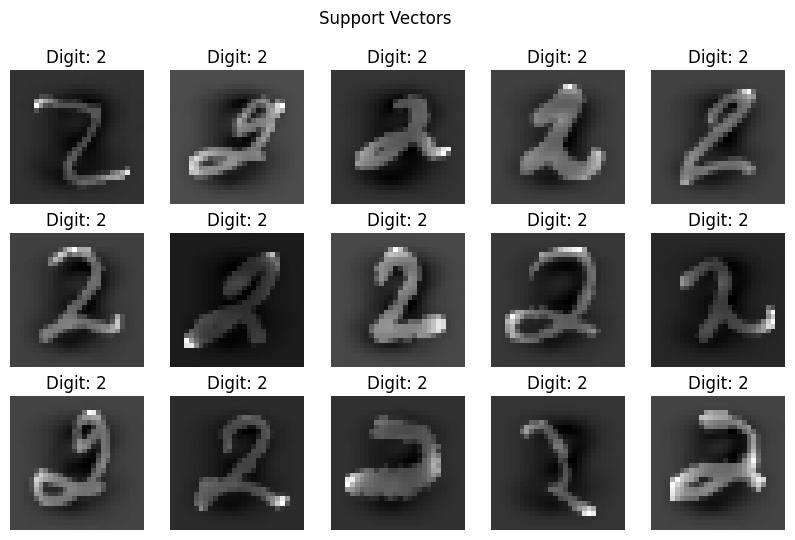

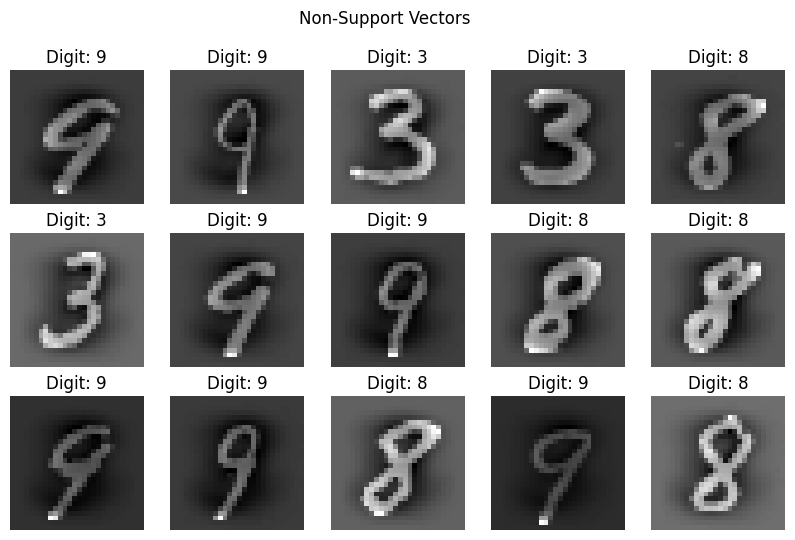

In [54]:
# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1]
}

# Initialize SVM with RBF kernel
svc = SVC(kernel='rbf')

# Measure training time for scikit-learn implementation
start_time = time.time()
# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
sklearn_training_time = time.time() - start_time
print(f"scikit-learn implementation training time: {sklearn_training_time} seconds")

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_svc = grid_search.best_estimator_

# Evaluate on training and test data
train_accuracy = best_svc.score(X_train, y_train)
test_accuracy = best_svc.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Extract support vectors
support_vectors = best_svc.support_
support_vectors_X = X_train[support_vectors]
support_vectors_y = np.array(y_train)[support_vectors]

# Visualize support vectors
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(support_vectors_X[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Digit: {support_vectors_y[i]}")
    axes[i].axis('off')

plt.suptitle('Support Vectors')
plt.show()

# Visualize some non-support vectors for comparison
non_support_indices = np.setdiff1d(np.arange(len(X_train)), support_vectors)
non_support_vectors_X = X_train[non_support_indices][:15]
non_support_vectors_y = np.array(y_train)[non_support_indices][:15]

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(non_support_vectors_X[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Digit: {non_support_vectors_y[i]}")
    axes[i].axis('off')

plt.suptitle('Non-Support Vectors')
plt.show()